# Import Package

In [1]:
import random

In [2]:
SEED = random.randint(1, 1000)
print(SEED)
SEED = 950
# 基本套件
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Categorical Data Transforming
import category_encoders as ce
from sklearn.impute import KNNImputer

# Change Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# 資料集切割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold

# 特徵篩選
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# 使用模型
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# import tensorflow as tf


# 資料視覺化
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# 最佳化參數
import optuna

os.getcwd()

248


C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'C:\\Users\\USER\\Desktop\\Kev\\碩一\\人工智慧\\HW2'

# Read data

In [3]:
df = pd.read_csv(r'./train.csv')
print('view the data shape', df.shape)
df.head()

view the data shape (10108, 9)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,2008/9/30,Female,Service,No,2,3.0,3.8,0.16
1,1,2008/11/30,Male,Service,Yes,1,2.0,5.0,0.36
2,2,2008/3/10,Female,Product,Yes,2,NaN,5.8,0.49
3,3,2008/11/3,Male,Service,Yes,1,1.0,2.6,0.20
4,4,2008/7/24,Female,Service,No,3,7.0,6.9,0.52


In [4]:
# elliminate traget not na
df = df[df['Burn Rate'].notna()]

In [5]:
df = df[df.columns[1:]]
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

C:\Users\USER\AppData\Local\Temp\ipykernel_15060\58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<AxesSubplot: >

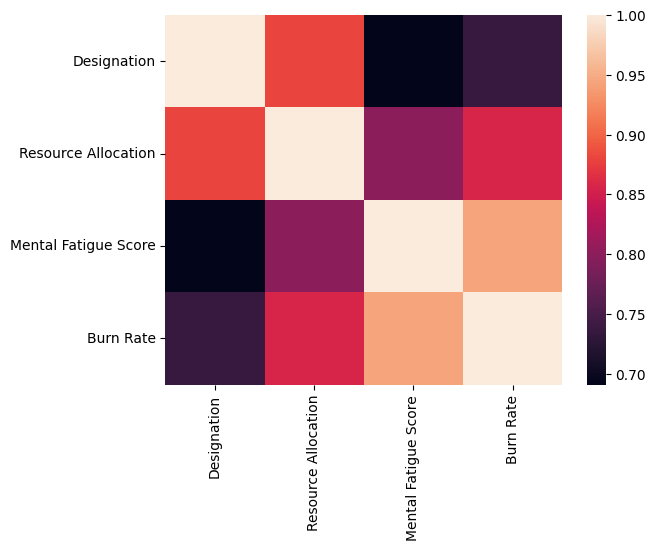

In [6]:
sns.heatmap(df.corr())

In [7]:
df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,9624.000000,9041.000000,8738.000000,9624.000000
mean,2.183292,4.500055,5.731231,0.452351
std,1.141031,2.051501,1.921508,0.198787
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.320000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


# Data Preprocessing

## Transfer Time related Data

In [8]:
def transfer_date(date):
    date_format = "%Y/%m/%d"
    a = datetime.strptime('2022/10/10', date_format)
    b = datetime.strptime(date, date_format)
    delta = a - b
    return delta.days

In [9]:
X['Date of Joining'] = X['Date of Joining'].apply(lambda x : transfer_date(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_15060\1446608504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date of Joining'] = X['Date of Joining'].apply(lambda x : transfer_date(x))


In [10]:
X['Date of Joining'].describe()

count    9624.000000
mean     5214.568579
std       105.818250
min      5031.000000
25%      5123.000000
50%      5213.000000
75%      5308.000000
max      5396.000000
Name: Date of Joining, dtype: float64

## Categorical Data Transforming -  Target Encoder

In [11]:
## 原類別型
ce_leave = ce.MEstimateEncoder(cols = ['Gender','Company Type','WFH Setup Available'], handle_unknown='value')
ce_leave.fit(X, y)     
X = ce_leave.transform(X)

## Normalize Data

In [12]:
# Normalization
Normalize_scaler = MinMaxScaler()
X = pd.DataFrame(Normalize_scaler.fit_transform(X), columns=X.columns, index=X.index)

## Fill Missing Value - KNN Imputer

In [13]:
X.isna().sum()

Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     583
Mental Fatigue Score    886
dtype: int64

In [14]:
# TODO
imputer = KNNImputer(n_neighbors=4)
X = pd.DataFrame(imputer.fit_transform(X),columns = X.columns)

In [15]:
X.isna().sum()

Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64

In [16]:
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)

# EDA

<AxesSubplot: >

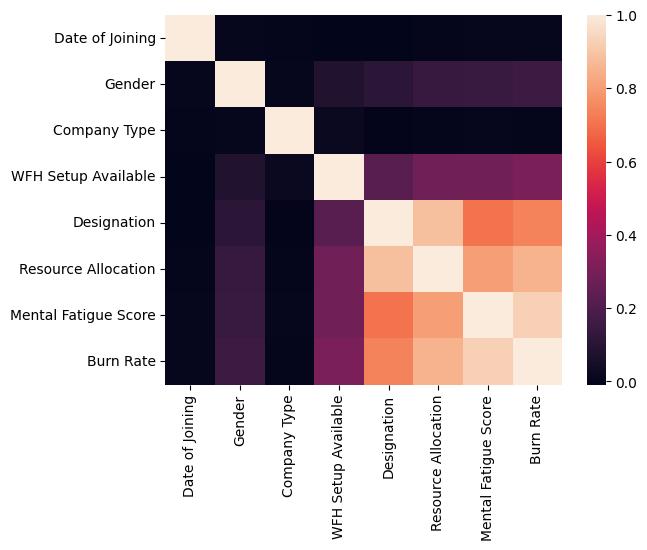

In [17]:
df = pd.concat([X,y],axis=1)
sns.heatmap(df.corr())

# Feature Selection

In [18]:
# TODO
df = df.loc[:,~df.columns.isin(['Date of Joining', 'Company Type','Gender'])]

# Modeling

## Hypterparameter tuning - Optuna

In [19]:
#optuna to set the hyperparameter of XGBoost
def objective_xgb(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000, 100),
        'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
        'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0)
    }
    model = xgb.XGBRegressor(**param,tree_method='gpu_hist',random_state=SEED).fit(X_train,y_train['Burn Rate'])
    y_pred = model.predict(X_valid)
    pred_list = y_pred.tolist()
    act_list = y_valid['Burn Rate'].tolist()

    error_list = []   
    for i in range(0, len(y_pred)):
        error_list.append(abs(round(act_list[i] - pred_list[i], 4)))
    abs_error_list_r4 =  [abs(ele) for ele in error_list]
    
    return sum(abs_error_list_r4)/len(abs_error_list_r4)

In [20]:
# 分成不同盒子 - 分層抽樣用
def get_box(df):
    Y1_list = []
    for Y1 in df['Burn Rate']: 
        if (Y1 > np.percentile(df['Burn Rate'], 80)):
            Y1_list.append('3')
        elif (Y1 < np.percentile(df['Burn Rate'], 20)):
            Y1_list.append('2')
        else:
            Y1_list.append('1')
    df['box'] = Y1_list
    return df

In [21]:
# 分層抽樣因子
df = get_box(df)

X = df[df.columns[:-2]]
y = df[df.columns[-2:]]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y['box'])

In [22]:
# # optuna
# study_xgb = optuna.create_study(direction="minimize")
# study_xgb.optimize(objective_xgb, n_trials=100, n_jobs=4)

## Training (model construction)

In [23]:
y = y[y.columns[0]]

In [24]:
# This hyperparameter set was decided by some micro-adjustment process based on the result previously generated by Optuna.

best_param_1 = {'max_depth': 6,
 'subsample': 0.9807247151163194,
 'n_estimators': 1800,
 'eta': 0.005119323915143175,
 'alpha': 4.4860920065321045e-06,
 'lambda': 3.99038649363455e-06,
 'gamma': 0.0018736038708502495,
 'min_child_weight': 10,
 'grow_policy': 'depthwise',
 'colsample_bytree': 0.7638067121388866}

In [25]:
# TODO
# build model with best hyperparameter
model_xgb = xgb.XGBRegressor(**best_param_1,random_state=SEED).fit(X,y)

## Cross validation
- usually we will do cross validation to evaluate the generalization of model
- or you can just use ```sklearn.model_selection.train_test_split``` to evaluate your model

In [26]:
# # TODO
# # Using Stratified K fold to find result
# # skf = StratifiedKFold(n_splits=5,random_state=SEED)

# scores = cross_val_score(model_xgb, X, y, cv=5)
# print("R2: %0.2f (std: %0.2f)" % (scores.mean(), scores.std()))
# print(scores)
# # need other scoring
# scores = cross_validate(model_xgb, X, y, cv=5,
#                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))
# print("====================================")
# print("R2: {} (std: {})".format(scores['test_r2'].mean(), scores['test_r2'].std()))
# print("MSE: {} (std: {})".format(-scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std()))
# print("MAPE: {} (std: {})".format(-scores['test_neg_mean_absolute_percentage_error'].mean(), scores['test_neg_mean_absolute_percentage_error'].std()))

# Prediction
1. read data
2. model prediction
3. to_csv

In [27]:
df_test = pd.read_csv(r'./test.csv')
print(df_test.shape)
df_test.head()

(1980, 8)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,0,2008/11/12,Male,Service,Yes,0,1.0,0.0
1,1,2008/3/11,Male,Product,No,3,8.0,7.9
2,2,2008/4/3,Male,Service,No,4,9.0,8.1
3,3,2008/10/1,Male,Product,No,1,3.0,5.7
4,4,2008/1/5,Female,Service,No,3,5.0,NaN


In [28]:
X_test = df_test[df_test.columns[1:]]

## Data Preprocessing for testing

## Transfer Time related Data

In [29]:
def transfer_date(date):
    date_format = "%Y/%m/%d"
    a = datetime.strptime('2022/10/10', date_format)
    b = datetime.strptime(date, date_format)
    delta = a - b
    return delta.days

In [30]:
X_test['Date of Joining'] = X_test['Date of Joining'].apply(lambda x : transfer_date(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_15060\345012162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date of Joining'] = X_test['Date of Joining'].apply(lambda x : transfer_date(x))


## Categorical Data Transforming -  Target Encoder

In [31]:
## 原類別型
X_test = ce_leave.transform(X_test)

## Normalize Data

In [32]:
# Normalization
X_test = pd.DataFrame(Normalize_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

## Fill Missing Value - KNN Imputer

In [33]:
X_test.isna().sum()

Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     110
Mental Fatigue Score    186
dtype: int64

In [34]:
X_test = pd.DataFrame(imputer.transform(X_test),columns = X_test.columns)

## Feature Selection

In [35]:
# TODO
X_test = X_test.loc[:,~X_test.columns.isin(['Date of Joining', 'Company Type','Gender'])]

## Predict Testing set

In [36]:
y_pred = model_xgb.predict(X_test)

In [37]:
y_pred_output = []
for i in y_pred:
    if i<0:
        y_pred_output.append(0)
    elif i>1:
        y_pred_output.append(1)
    else:
        y_pred_output.append(i)
        
y_pred_output = pd.DataFrame(y_pred_output,columns=['Burn Rate'])

# Output .csv for submission

In [38]:
df_ans = pd.DataFrame(y_pred_output.astype(float), columns=['Burn Rate'])
df_ans.to_csv('mySubmission.csv', index_label='Employee ID')

In [39]:
df_ans

,Burn Rate
0,0.004374
1,0.754634
2,0.770507
3,0.409425
4,0.490788
...,...
1975,0.180735
1976,0.455782
1977,0.343214
1978,0.585250
